In [1]:
!pip install imblearn
!pip install keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [3]:

df = pd.read_csv('orders.csv')

df['Cancel Time'] = df['Cancel Time'].fillna(np.nan)
df['Reject Time'] = df['Reject Time'].fillna(np.nan)


df['target'] = np.where( df['Cancel Time'].isnull(), 0, 1 )
df['target'] = np.where(df['Reject Time'].isnull(), df['target'], 1)



df['Cancel Time'] = pd.to_datetime(df['Cancel Time'])
df['Reject Time'] = pd.to_datetime(df['Reject Time'])

#for orders cancelled nby customer
df['Customer Hour'] = np.where(df['target'].isin([1]), df['Cancel Time'].dt.hour, np.nan)


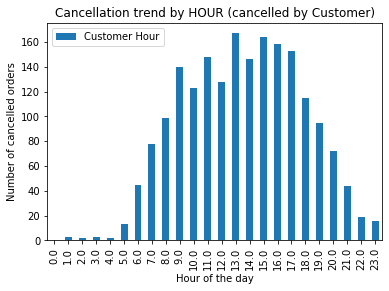

In [4]:

ax = df.groupby(['Customer Hour']).agg({'Customer Hour' : np.count_nonzero}).plot(kind='bar')
ax.set(xlabel='Hour of the day', ylabel='Number of cancelled orders', title='Cancellation trend by HOUR (cancelled by Customer)')
plt.show()
#for order cancelled by driver
df['Driver Hour'] = np.where(df['target'].isin([1]), df['Reject Time'].dt.hour, np.nan)


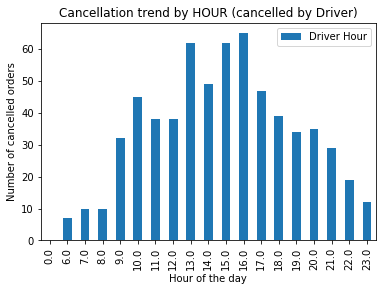

In [5]:

ax = df.groupby(['Driver Hour']).agg({'Driver Hour' : np.count_nonzero}).plot(kind='bar')
ax.set(xlabel='Hour of the day', ylabel='Number of cancelled orders', title='Cancellation trend by HOUR (cancelled by Driver)')
plt.show()


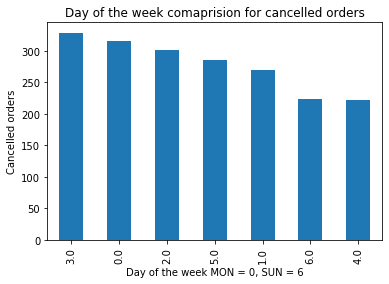

In [6]:
#day of the week
ax = df[df['target'].isin([1])]['Cancel Time'].dt.dayofweek.value_counts().plot(kind='bar')
ax.set(xlabel = 'Day of the week MON = 0, SUN = 6', ylabel='Cancelled orders', title='Day of the week comaprision for cancelled orders')
plt.show()


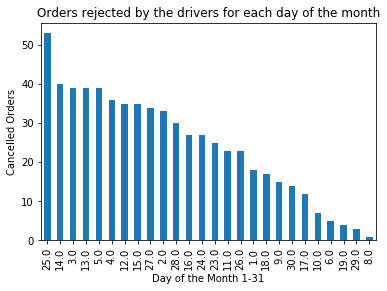

In [7]:
ax = df[df['target'].isin([1])]['Reject Time'].dt.day.value_counts().plot(kind='bar')
ax.set(xlabel='Day of the Month 1-31', ylabel='Cancelled Orders', title='Orders rejected by the drivers for each day of the month')
plt.show()


In [8]:
df['Placed Time'] = pd.to_datetime(df['Placed Time'])
#df['hour'] = df['Placed Time'].dt.hour
#df['day'] = df['Placed Time'].dt.dayofweek
#df['month'] = df['Placed Time'].dt.month
df['date'] = df['Placed Time'].dt.date


#check if weather has any effect on customer cancelleation 
#weather data taken from world weather online

w_df = pd.read_csv('hongkong.csv')
cols = ['date_time', 'tempC', 'windspeedKmph', 'visibility', 'cloudcover']
w_df = w_df[cols]

w_df['hour'] = pd.to_datetime(w_df['date_time']).dt.hour
w_df['day'] = pd.to_datetime(w_df['date_time']).dt.dayofweek
w_df['month'] = pd.to_datetime(w_df['date_time']).dt.month
w_df['date'] = pd.to_datetime(w_df['date_time']).dt.date

m_df = pd.merge(df, w_df, on=['date'], how='inner', indicator=True)


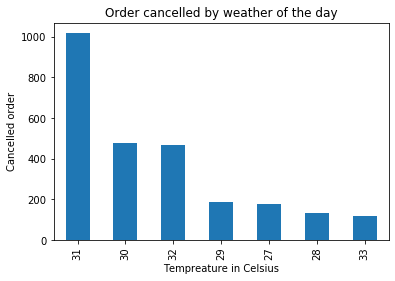

In [9]:

ax = m_df[m_df['target'].isin([1])]['tempC'].value_counts().plot(kind='bar')
ax.set(xlabel='Tempreature in Celsius', ylabel='Cancelled order', title='Order cancelled by weather of the day')
plt.show()


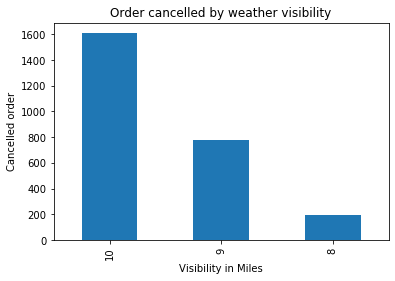

In [10]:


ax = m_df[m_df['target'].isin([1])]['visibility'].value_counts().plot(kind='bar')
ax.set(xlabel='Visibility in Miles', ylabel='Cancelled order', title='Order cancelled by weather visibility')
plt.show()


In [11]:

def clean_data(df):
    
    y = df['target']
        
    cols = ['Available Drivers', 'Response Distance', 'Service Type', 'hour', 'day', 'tempC', 'windspeedKmph', 'visibility', 'cloudcover']
    
    df = df[cols]
    
    #convert data types
    df['Service Type'] = df['Service Type'].map({'Van' : 1, 'Motorcycle' : 0})
    df['Response Distance'] = df['Response Distance'].round().fillna(0.0).astype(int)
    
    df['Response Distance'] = df['Response Distance'] / 100
    
    x = df[cols]
    
    #scale the data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    return x,y, cols


x , y, cols = clean_data(m_df)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)

In [13]:
sm = SMOTE(random_state=12, ratio=.5)

In [14]:
x_train_rs, y_train_rs = sm.fit_sample(x_train, y_train)

In [15]:
clf = LogisticRegression().fit(x_train_rs, y_train_rs)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
pred = clf.predict(x_test)

In [17]:
pd.crosstab(pred, y_test, rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,4077,678
1,141,48


In [18]:
x_train.shape

(11536, 9)

In [19]:
x_train_rs.shape

(14520, 9)

In [20]:
np.cov(x)

array([[2.08668349, 2.04675247, 2.20591669, ..., 0.15021128, 0.23140941,
        0.27832849],
       [2.04675247, 2.01986201, 2.15321825, ..., 0.18163767, 0.23357837,
        0.26532752],
       [2.20591669, 2.15321825, 3.32466554, ..., 0.12566656, 0.1321751 ,
        0.80939124],
       ...,
       [0.15021128, 0.18163767, 0.12566656, ..., 0.25178214, 0.1806232 ,
        0.03336138],
       [0.23140941, 0.23357837, 0.1321751 , ..., 0.1806232 , 0.18592387,
        0.00826374],
       [0.27832849, 0.26532752, 0.80939124, ..., 0.03336138, 0.00826374,
        2.0107195 ]])

In [21]:
x_covariance_matrix = np.cov(x.T)

In [22]:
eig_vals, eig_vecs = np.linalg.eig(x_covariance_matrix)

print('Eigen vectors ', eig_vecs)
print('Eig values', eig_vals)

Eigen vectors  [[-0.19084265  0.06093426 -0.58338975 -0.03170995 -0.77230577 -0.06227732
   0.11796859 -0.06531239  0.        ]
 [ 0.04958181  0.00480919  0.53227371  0.01655688 -0.32732287  0.08427298
   0.74084999  0.22545105  0.        ]
 [-0.05860925 -0.01938838 -0.55439772 -0.01287218  0.4741494  -0.10367609
   0.48046903  0.47143361  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.18779715 -0.01977591  0.15222174 -0.08033543 -0.22242423 -0.57598052
  -0.35218841  0.65532674  0.        ]
 [-0.57180857  0.67258216  0.13042106  0.4081822   0.05254442 -0.01392507
  -0.0927137   0.15967212  0.        ]
 [-0.06958566  0.08585054  0.05965801 -0.04175502  0.12854253 -0.79680368
   0.26501931 -0.51071561  0.        ]
 [-0.49066231  0.05538233  0.1219366  -0.8543235   0.05288977  0.06030409
  -0.03775332  0.05989079  0.        ]
 [ 0.59149067  0.72985794 -0.10186039 -0.30639199  0.00564951  0.08826496
   0.04561963 -

In [23]:
eig_pairs = {k : v for k,v in zip(eig_vals, eig_vecs)}

In [24]:
sorted(eig_vals, reverse=True)

tot = sum(eig_vals)
var_exp = [(i/tot) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


In [25]:
print('variance ', var_exp)
print('Cummalative sum ', cum_var_exp)

variance  [30.544737475458327, 17.220484774586993, 13.319424744286898, 11.139110032195623, 10.818551555406984, 8.82608210401303, 6.517438591193417, 1.6141707228587363, 0.0]
Cummalative sum  [ 30.54473748  47.76522225  61.08464699  72.22375703  83.04230858
  91.86839069  98.38582928 100.         100.        ]


In [26]:
col_dict = {k:v for k,v in zip(cols, cum_var_exp)}
col_dict

{'Available Drivers': 30.544737475458327,
 'Response Distance': 47.76522225004532,
 'Service Type': 61.08464699433222,
 'hour': 72.22375702652784,
 'day': 83.04230858193482,
 'tempC': 91.86839068594784,
 'windspeedKmph': 98.38582927714126,
 'visibility': 99.99999999999999,
 'cloudcover': 99.99999999999999}

In [27]:
#as we can see, 7 columns contribute to 98% of our accuracy so we can safely drop 2 columns

In [28]:
'''
pca = PCA(n_components=7)
x_train = pca.fit_transform(x_train_rs)
y_train = to_categorical(y_train_rs)
'''

'\npca = PCA(n_components=7)\nx_train = pca.fit_transform(x_train_rs)\ny_train = to_categorical(y_train_rs)\n'

In [29]:
#make a keras model and check accuracy

In [40]:
x_train_rs.shape

(14520, 9)

In [45]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_rs, to_categorical(y_train_rs), epochs=50, validation_split=0.3, batch_size=50)

Train on 10164 samples, validate on 4356 samples
Epoch 1/50
10164/10164 [==============================] - 1s 52us/step - loss: 0.4434 - accuracy: 0.8338 - val_loss: 1.1842 - val_accuracy: 0.2945
Epoch 2/50
10164/10164 [==============================] - 0s 32us/step - loss: 0.3989 - accuracy: 0.8535 - val_loss: 1.2155 - val_accuracy: 0.3983
Epoch 3/50
10164/10164 [==============================] - 0s 30us/step - loss: 0.3837 - accuracy: 0.8598 - val_loss: 1.1828 - val_accuracy: 0.4578
Epoch 4/50
10164/10164 [==============================] - 0s 32us/step - loss: 0.3785 - accuracy: 0.8612 - val_loss: 1.1471 - val_accuracy: 0.4532
Epoch 5/50
10164/10164 [==============================] - 0s 33us/step - loss: 0.3742 - accuracy: 0.8649 - val_loss: 1.1664 - val_accuracy: 0.4479
Epoch 6/50
10164/10164 [==============================] - 0s 32us/step - loss: 0.3738 - accuracy: 0.8653 - val_loss: 1.1402 - val_accuracy: 0.4679
Epoch 7/50
10164/10164 [==============================] - 0s 33us/ste